# Downloads and Imports

In [44]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm

In [45]:
pip install pyLDAvis==2.1.2

In [46]:
pip install squarify

In [47]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np

from apiclient.discovery import build
import re
from PIL import Image

import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from textblob import TextBlob
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_lg
nlp = spacy.load('en_core_web_lg')

import squarify
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Youtube API

In [48]:
api_key = SECRETKEY
youtube = build('youtube', 'v3', developerKey=api_key)

In [49]:
def find_channel_upload_id(youtube_user_name: str) -> str:
  """
  Description
  -----------
  This function takes any username from YouTube, makes a request to the api, drills into the data, then outputs
  their upload_id.

  Parameters
  ----------
  youtube_user_name: string
  
  Returns
  -------
  channel_data: string
  """
  channel_data = youtube.channels().list(part="contentDetails",
                                         forUsername=f"{youtube_user_name}").execute()
  return channel_data['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [50]:
find_channel_upload_id("MrBeast6000")

'UUX6OQ3DkcsbYNE6H8uQQuVA'

In [51]:
def get_video_list(upload_id: str) -> list:
  """
  Description
  -----------
  This function will get a list of videos from a playlist. Since there's a limit of 50 responses per page,
  I've created a while loop that checks if there's any additional pages of comments. If there's no remaining
  comments, the while loop will stop, and it will return the desired video list.

  Parameters
  ----------
  upload_id: string
  
  Returns
  -------
  video_list: list[string]
  """
  video_list = []
  request = youtube.playlistItems().list(part="snippet,contentDetails", playlistId=upload_id, maxResults=50)
  next_page = True

  while next_page:
      response = request.execute()
      data = response['items']

      for video in data:
          video_id = video['contentDetails']['videoId']
          if video_id not in video_list:
              video_list.append(video_id)

      if 'nextPageToken' in response.keys():
          next_page = True
          request = youtube.playlistItems().list(part="snippet,contentDetails", playlistId=upload_id,
                                                  pageToken=response['nextPageToken'], maxResults=50)

      else:
          next_page = False

  return video_list

In [ ]:
video_list = get_video_list(find_channel_upload_id("MrBeast6000"))
video_list

In [53]:
def get_video_details(video_list: list) -> pd.DataFrame:
  """
  Description
  -----------
  Once we have our video list we can pass it to this function to get details about each video, such as like count,
  comment count, ect.Then, after we have all of those details - the function takes that list and converts it to a
  Pandas Dataframe, properly formats some columns, and adds a few additional columns.The actions are limited to 50
  per request, so I've included a bypass for that as well.

  Parameters
  ----------
  video_list: list[string]
  
  Returns
  -------
  df: DataFrame
  """
  stats_list = []

  for i in range(0, len(video_list), 50):
      request = youtube.videos().list(part="snippet,contentDetails,statistics", id=video_list[i:i + 50])
      data = request.execute()

      for video in data['items']:
          title = video['snippet']['title']
          video_id = video['id']
          published = video['snippet']['publishedAt']
          description = video['snippet']['description']
          view_count = video['statistics'].get('viewCount', 0)
          like_count = video['statistics'].get('likeCount', 0)
          dislike_count = video['statistics'].get('dislikeCount', 0)
          comment_count = video['statistics'].get('commentCount', 0)
          stats_dict = dict(video_id=video_id, title=title, description=description, published=published,
                            view_count=view_count, like_count=like_count, dislike_count=dislike_count,
                            comment_count=comment_count)
          stats_list.append(stats_dict)

  df = pd.DataFrame(stats_list)
  df['title_length'] = df['title'].str.len()
  df["view_count"] = pd.to_numeric(df["view_count"])
  df["like_count"] = pd.to_numeric(df["like_count"])
  df["dislike_count"] = pd.to_numeric(df["dislike_count"])
  df["comment_count"] = pd.to_numeric(df["comment_count"])
  df["reactions"] = df["like_count"] + df["dislike_count"] + df["comment_count"] + df["comment_count"]

  return df.sort_values(by="view_count", ascending=False)

In [54]:
video_details = get_video_details(video_list)
video_details

,video_id,title,description,published,view_count,like_count,dislike_count,comment_count,title_length,reactions
4,0e3GPea1Tyg,"$456,000 Squid Game In Real Life!",MAKE SURE YOU WATCH UNTIL GLASS BRIDGE IT'S IN...,2021-11-24T21:00:01Z,222913691,13170942,0,598516,33,14367974
51,r7zJ8srwwjk,I Spent 50 Hours In Solitary Confinement,i borderline went crazy about 30 hours in...\n...,2020-05-30T20:10:08Z,169380134,3255698,0,108152,40,3472002
20,9bqk6ZUsKyA,I Spent 50 Hours Buried Alive,This was the most insane thing I’ve ever done\...,2021-03-27T20:00:04Z,165759347,5606245,0,236354,29,6078953
31,GLoeAJUcz38,"Press This Button To Win $100,000!",Push the red subscribe button and you could al...,2020-11-14T21:00:02Z,157914261,2905201,0,85803,34,3076807
146,3TflpIllQHY,I Put 100 Million Orbeez In My Friend's Backyard,THIS WAS THE CRAZIEST THING WE HAVE EVER DONE ...,2018-11-22T21:08:01Z,156239128,4100362,0,137261,48,4374884
...,...,...,...,...,...,...,...,...,...,...
471,eBklqeeIu10,I Hate Spam On Youtube,This is just a little rant about spam and then...,2015-07-12T19:08:52Z,15195,563,0,198,22,959
412,pGYyUssWLTA,Social Media As A Job????,Did you know people are litterally paid to do ...,2015-08-29T18:20:31Z,15093,602,0,182,25,966
444,ZQZzR0DUujc,New Optic Gaming Gear Coming To Advanced Warfa...,This video is just my thoughts on the new opti...,2015-08-01T16:47:55Z,15041,397,0,125,61,647
491,UCYefSGBP00,The Truth About Big Community Channels,Ever tried to get your video up on a big commu...,2015-06-22T16:32:02Z,15013,539,0,297,38,1133


In [55]:
def get_comment_threads(video_id: str) -> pd.DataFrame:
  """
  Description
  -----------
  This function takes in the specified video id, drills down to retrieve all the associated comments to that video,
  then outputs all of those comments in a list.

  Parameters
  ----------
  video_id: string
  
  Returns
  -------
  df: DataFrame
  """
  request = youtube.commentThreads().list(part="snippet", maxResults=50, videoId=video_id)
  comment_list = []
  next_page = True

  while next_page:
      response = request.execute()
      data = response['items']

      for comment in data:
          comment_id = comment['id']
          comment_text = comment["snippet"]['topLevelComment']['snippet']['textDisplay']
          comment_replies = comment['snippet']['totalReplyCount']
          comment_dict = dict(comment_id=comment_id, comment_text=comment_text, comment_replies=comment_replies)
          comment_list.append(comment_dict)

      if 'nextPageToken' in response.keys():
          next_page = True
          request = youtube.commentThreads().list(part="snippet", videoId=video_id,
                                                  pageToken=response['nextPageToken'], maxResults=50)

      else:
          next_page = False

  df = pd.DataFrame(comment_list)
  df['comment_length']=df['comment_text'].apply(lambda x:len(x))

  return df.sort_values(by="comment_replies", ascending=False)

In [56]:
data = get_comment_threads("jLxVzfpvGXI")
data

,comment_id,comment_text,comment_replies,comment_length
123,UgzdxS_z722RJBfAcMZ4AaABAg,We definitely need different social media outl...,21,416
130,UgwELrprtyIUCYibqBd4AaABAg,Problem with truth social is that people will ...,19,153
122,UgyG3GnuthVv3Llbdq14AaABAg,product is DOA. the name is silly and only con...,17,121
129,UgyuagMbunrdzvLxhSp4AaABAg,"Classic. Someone gets silenced on a platform, ...",15,96
99,UgyGmXKQeBVTDZvBS2t4AaABAg,I’m still stuck on the waiting list 3 days in....,13,103
...,...,...,...,...
29,UgwAeke0JW5G9wUW82N4AaABAg,and it crashed,0,14
30,UgzjwBi0Y4zNH19p8mR4AaABAg,"as crazy as it sounds, some people like being ...",0,169
69,UgwYGp8l7jmX6qyLyCF4AaABAg,I got a Lew AD on a Lew later clip,0,34
68,UgwvcCC6YK5BtNDqC5B4AaABAg,For a guy that used personal information from ...,0,203


# EDA On The Specified YouTube Video.

In [57]:
def clean_text_data(text: str) -> str:
  """
  Description
  -----------
  Accepts a string and performs several regex substitutions in order to clean the document. 
  
  Parameters
  ----------
  text: string or object
  
  Returns
  -------
  text: string or object
  """

  text = ''.join((item for item in text if not item.isdigit()))

  b_tag_regex = r'<.*?>'
  punct_regex = r"[^0-9a-zA-Z\s]" 
  special_chars_regex = r"[\$\%\&\@+]"

  text = re.sub(b_tag_regex, "", text)
  text = re.sub(punct_regex, "", text)
  text = re.sub(special_chars_regex, "", text)

  text = text.lower()
  return text

In [58]:
data['cleaned'] = data['comment_text'].apply(clean_text_data)
data

,comment_id,comment_text,comment_replies,comment_length,cleaned
123,UgzdxS_z722RJBfAcMZ4AaABAg,We definitely need different social media outl...,21,416,we definitely need different social media outl...
130,UgwELrprtyIUCYibqBd4AaABAg,Problem with truth social is that people will ...,19,153,problem with truth social is that people will ...
122,UgyG3GnuthVv3Llbdq14AaABAg,product is DOA. the name is silly and only con...,17,121,product is doa the name is silly and only cons...
129,UgyuagMbunrdzvLxhSp4AaABAg,"Classic. Someone gets silenced on a platform, ...",15,96,classic someone gets silenced on a platform th...
99,UgyGmXKQeBVTDZvBS2t4AaABAg,I’m still stuck on the waiting list 3 days in....,13,103,im still stuck on the waiting list days in lu...
...,...,...,...,...,...
29,UgwAeke0JW5G9wUW82N4AaABAg,and it crashed,0,14,and it crashed
30,UgzjwBi0Y4zNH19p8mR4AaABAg,"as crazy as it sounds, some people like being ...",0,169,as crazy as it sounds some people like being c...
69,UgwYGp8l7jmX6qyLyCF4AaABAg,I got a Lew AD on a Lew later clip,0,34,i got a lew ad on a lew later clip
68,UgwvcCC6YK5BtNDqC5B4AaABAg,For a guy that used personal information from ...,0,203,for a guy that used personal information from ...


In [59]:
def get_lemmas(text: str) -> list:
  """
  Description
  -----------
  Creates lemma tokens for further analytics. (ie Lemmas = Plural nouns with funky spellings get transformed to singular tense.) This function also removes all stop words from the sentance, punctiation (if any), and filters whitespace created in the process.
  
  Parameters
  ----------
  text: string or object
  
  Returns
  -------
  output: list of strings
  """
  lemmas = []
  doc = nlp(text)

  for token in doc: 
      if ((token.is_stop == False) and (token.is_punct == False) and
          (token.pos_ != 'PRON')) and len(token) > 1:
          lemmas.append(token.lemma_)

  return lemmas

In [60]:
data['lemmas'] = data['cleaned'].apply(get_lemmas)
data

,comment_id,comment_text,comment_replies,comment_length,cleaned,lemmas
123,UgzdxS_z722RJBfAcMZ4AaABAg,We definitely need different social media outl...,21,416,we definitely need different social media outl...,"[definitely, need, different, social, medium, ..."
130,UgwELrprtyIUCYibqBd4AaABAg,Problem with truth social is that people will ...,19,153,problem with truth social is that people will ...,"[problem, truth, social, people, bored, conser..."
122,UgyG3GnuthVv3Llbdq14AaABAg,product is DOA. the name is silly and only con...,17,121,product is doa the name is silly and only cons...,"[product, doa, silly, conservative, want, sign..."
129,UgyuagMbunrdzvLxhSp4AaABAg,"Classic. Someone gets silenced on a platform, ...",15,96,classic someone gets silenced on a platform th...,"[classic, get, silence, platform, create, plat..."
99,UgyGmXKQeBVTDZvBS2t4AaABAg,I’m still stuck on the waiting list 3 days in....,13,103,im still stuck on the waiting list days in lu...,"[stick, waiting, list, day, luckily, mark, get]"
...,...,...,...,...,...,...
29,UgwAeke0JW5G9wUW82N4AaABAg,and it crashed,0,14,and it crashed,[crash]
30,UgzjwBi0Y4zNH19p8mR4AaABAg,"as crazy as it sounds, some people like being ...",0,169,as crazy as it sounds some people like being c...,"[crazy, sound, people, like, censor, platform,..."
69,UgwYGp8l7jmX6qyLyCF4AaABAg,I got a Lew AD on a Lew later clip,0,34,i got a lew ad on a lew later clip,"[get, lew, ad, lew, later, clip]"
68,UgwvcCC6YK5BtNDqC5B4AaABAg,For a guy that used personal information from ...,0,203,for a guy that used personal information from ...,"[guy, personal, information, people, collect, ..."


In [61]:
def word_count(tokens: list) -> pd.DataFrame:
  """
  Description
  -----------
  Calculates some basic statistics about tokens in the specified corpus.

  Parameters
  ----------
  tokens: list of strings
  
  Returns
  -------
  output: DataFrame
  """
  word_counts = Counter()
  appears_in = Counter()
  total_docs = len(tokens)

  for token in tokens:
      word_counts.update(token)
      appears_in.update(set(token))
  
  temp = zip(word_counts.keys(), word_counts.values())
  wc = pd.DataFrame(temp, columns = ['word', 'count'])
  wc['rank'] = wc['count'].rank(method='first', ascending=False)
  total = wc['count'].sum()
  wc['pct_total'] = wc['count'].apply(lambda token_count: token_count / total)
  wc = wc.sort_values(by='rank')
  wc['cul_pct_total'] = wc['pct_total'].cumsum()
  temp2 = zip(appears_in.keys(), appears_in.values())
  appears = pd.DataFrame(temp2, columns=['word', 'appears_in'])
  wc = appears.merge(wc, on='word')
  wc['appears_in_pct'] = wc['appears_in'].apply(lambda word: word / total_docs)

  return wc.sort_values(by='rank')

In [62]:
wc = word_count(data['lemmas'])
wc

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
59,trump,29,30,1.0,0.033076,0.033076,0.218045
34,truth,19,19,2.0,0.020948,0.054024,0.142857
125,not,14,18,3.0,0.019846,0.073870,0.105263
163,app,14,16,4.0,0.017641,0.091510,0.105263
211,go,9,12,5.0,0.013230,0.104741,0.067669
...,...,...,...,...,...,...,...
516,datum,1,1,515.0,0.001103,0.995590,0.007519
518,win,1,1,516.0,0.001103,0.996692,0.007519
517,positive,1,1,517.0,0.001103,0.997795,0.007519
513,spy,1,1,518.0,0.001103,0.998897,0.007519


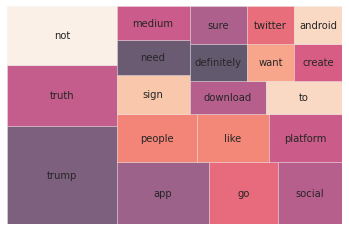

<Figure size 1440x1440 with 0 Axes>

In [63]:
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.7 )
plt.axis('off')
plt.figure(figsize=(20, 20));
plt.show();

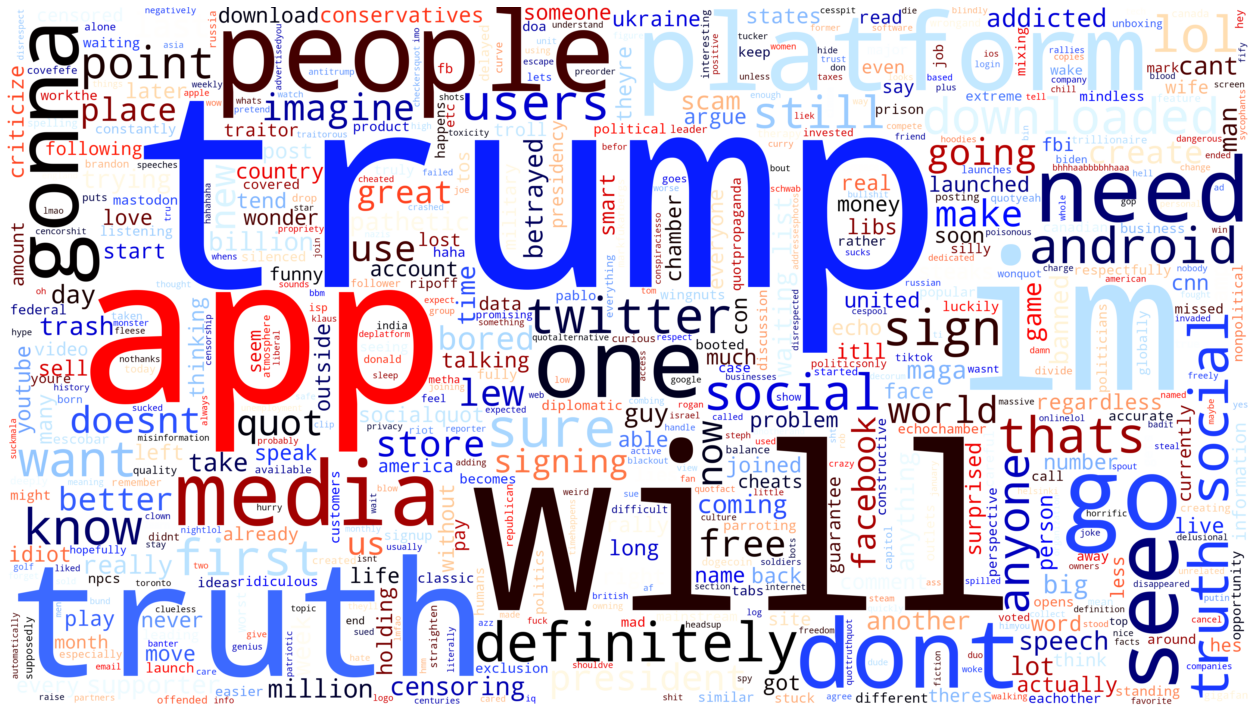

In [64]:
data['cleaned']=data['cleaned'].astype('str')
cleaned_text = " ".join(txt for txt in data.cleaned)
c_mask = np.array(Image.open("YouTube-logo.png"))

wc = WordCloud(background_color='white', mask=c_mask, mode='RGB',
               width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='black',colormap='flag')

wc.generate(cleaned_text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [65]:
id2word = corpora.Dictionary(data["lemmas"])
corpus = [id2word.doc2bow(text) for text in data["lemmas"]]
lda = LdaModel(corpus=corpus, id2word=id2word, random_state=42, num_topics=10, passes=1)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.048134  0.137680       1        1  17.281934
0     -0.084157 -0.090064       2        1  15.575614
4     -0.107516 -0.028956       3        1  12.130024
1      0.143105 -0.119488       4        1  11.029501
8      0.066312  0.040778       5        1   9.753441
7     -0.047831  0.048190       6        1   8.860311
5      0.014321 -0.023249       7        1   8.300138
9     -0.066987  0.011449       8        1   7.373282
6      0.023132  0.017910       9        1   5.689932
3      0.011487  0.005750      10        1   4.005822, topic_info=         Term       Freq      Total Category  logprob  loglift
62      trump  20.000000  20.000000  Default  30.0000  30.0000
37      truth  11.000000  11.000000  Default  29.0000  29.0000
50   platform   6.000000   6.000000  Default  28.0000  28.0000
72       sign   5.000000   5.000000  Default  27.0000  27.0000
210        go   9.000000   9.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
16       need   0.497485   5.335869  Topic10  -4.2909   0.8448
72       sign   0.447404   5.230434  Topic10  -4.3970   0.7586
482  military   0.160170   2.111162  Topic10  -5.4242   0.6387
37      truth   0.854051  11.996527  Topic10  -3.7505   0.5750
62      trump   0.508511  20.160760  Topic10  -4.2690  -0.4626

[490 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
130       3  0.773404          
130       8  0.386702          
511       2  0.759328    access
175       2  0.493967   account
82        3  0.528201  actually
...     ...       ...       ...
120       2  0.318123     world
120       3  0.318123     world
120       6  0.318123     world
215       6  0.862068  wrongand
505       7  0.822063      year

[509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 9, 8, 6, 10, 7, 4])

# TextBlob Setiment Breakdown

In [66]:
def get_subjectivity(text:str) -> float:
  """
  Description
  -----------
  Accepts a string and rates the subjectivity score based on TextBlob's rankings.
  
  Parameters
  ----------
  text: string or object
  
  Returns
  -------
  output: float
  """
  return TextBlob(text).sentiment.subjectivity

In [67]:
data['subjectivity'] = data['cleaned'].apply(get_subjectivity)

In [68]:
def get_polarity(text:str) -> float:
  """
  Description
  -----------
  Accepts a string and rates the polarity score based on TextBlob's rankings.
  
  Parameters
  ----------
  text: string or object
  
  Returns
  -------
  output: float
  """
  return TextBlob(text).sentiment.polarity

In [69]:
data['polarity'] = data['cleaned'].apply(get_polarity)

In [70]:
def get_analysis(score: float) -> str:
  """
  Description
  -----------
  Takes in a score from the polarity column, then creates a discription stating the over all setiment depenent on the score.
  
  Parameters
  ----------
  score: float
  
  Returns
  -------
  output: string or object
  """
  if score < 0:
    return 'Negative'

  elif score == 0:
    return 'Neutral'
  
  return 'Positive'

In [71]:
data['sentiment'] = data['polarity'].apply(get_analysis)

In [72]:
def word_entity(cleaned_text_column: "pd.Series[str]") -> pd.DataFrame:
  """
  Description
  -----------
  First: Take all sentances from the cleaned reviews & puts it in a list. 
  Second: From all those sentances we take all the words and add them into a list.
  Third: Then we take all the words, join them on a space, then wrap them with spacy.
  Fourth: Finally we take all the wrapped spacy words, grab the entity assoicated (if any), then output a tupple with both the text & entity label.

  Parameters
  ----------
  cleaned_text_column: Series of strings
  
  Returns
  -------
  output: DataFrame
  """
  # First
  all_sentences = [sentance for sentance in cleaned_text_column]

  # Second
  words = []
  for sentance in all_sentences:    
      split_sentance = sentance.split()
      for word in split_sentance: 
        words.append(word)

  # Third
  stem2 = nlp(" ".join(words))

  # Fourth
  label = [(words.text, words.label_) for words in stem2.ents]

  return pd.DataFrame(label, columns = ['word','entity'])

## Positive Sentiment

In [73]:
df_positive = data.loc[data['sentiment']=='Positive']
positive_entities = word_entity(df_positive['cleaned'])
positive_entities.head(10)

,word,entity
0,quotpropaganda socialquot,PERSON
1,twitter,ORG
2,canadian,NORP
3,first,ORDINAL
4,pablo escobar,PERSON
5,donald trump gigafan,PERSON
6,india,GPE
7,markfukarbergs metha,PERSON
8,tiktok,ORG
9,android,ORG


In [74]:
entity_groups = positive_entities.groupby(['entity']).size().to_frame('count').reset_index()
entity_groups.sort_values(by='count', ascending=False)[:10]
fig = px.pie(entity_groups, values='count', names='entity', title='Positive Word & Entity Association')
fig.show()

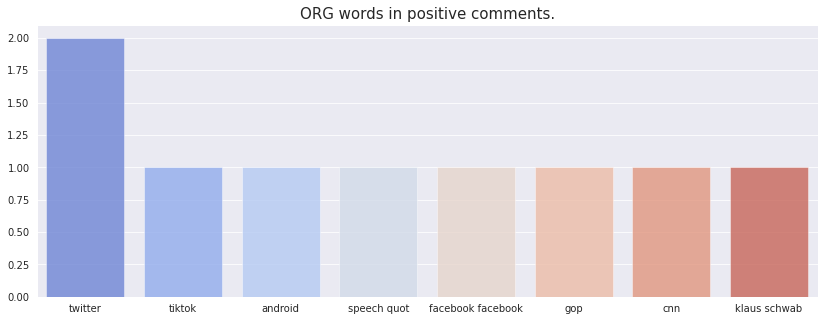

In [75]:
ORG = positive_entities.query("entity == 'ORG'")
ORG = ORG['word'].value_counts()
ORG = ORG[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(14,5));
ORG = sns.barplot(x=ORG.index,y= ORG.values, alpha=0.8,palette="coolwarm");
plt.title('ORG words in positive comments.',fontsize=15);
plt.show();

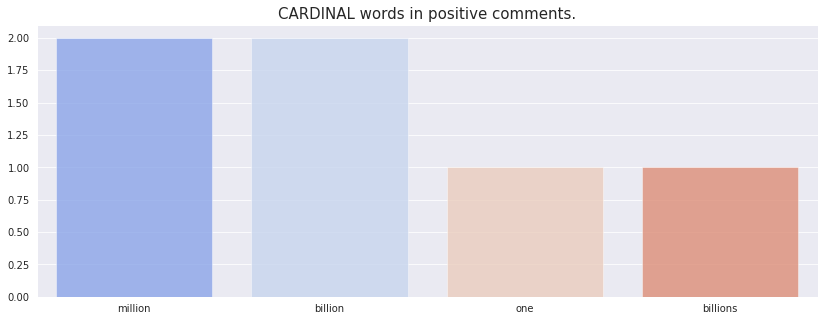

In [76]:
CARDINAL = positive_entities.query("entity == 'CARDINAL'")
CARDINAL = CARDINAL['word'].value_counts()
CARDINAL = CARDINAL[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(14,5));
CARDINAL = sns.barplot(x=CARDINAL.index,y= CARDINAL.values, alpha=0.8,palette="coolwarm");
plt.title('CARDINAL words in positive comments.',fontsize=15);
plt.show();

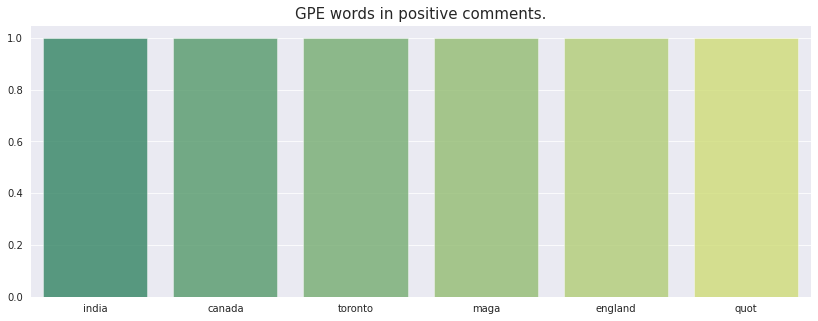

In [77]:
GPE = positive_entities.query("entity == 'GPE'")
GPE =GPE['word'].value_counts()
GPE = GPE[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(14,5));
GPE = sns.barplot(x=GPE.index,y= GPE.values, alpha=0.8,palette="summer");
plt.title('GPE words in positive comments.',fontsize=15);
plt.show();

## Negative Sentiment

In [78]:
df_negative = data.loc[data['sentiment']=='Negative']
negative_entities = word_entity(df_negative['cleaned'])
negative_entities.head(10)

,word,entity
0,conservatives,NORP
1,doa,ORG
2,us,GPE
3,cnn,ORG
4,dogecoin,ORG
5,us,GPE
6,asia,LOC
7,bbm,ORG
8,android,ORG
9,ios,ORG


In [79]:
entity_groups = negative_entities.groupby(['entity']).size().to_frame('count').reset_index()
entity_groups.sort_values(by='count', ascending=False)[:10]
fig = px.pie(entity_groups, values='count', names='entity', title='Negative Word & Entity Association')
fig.show()

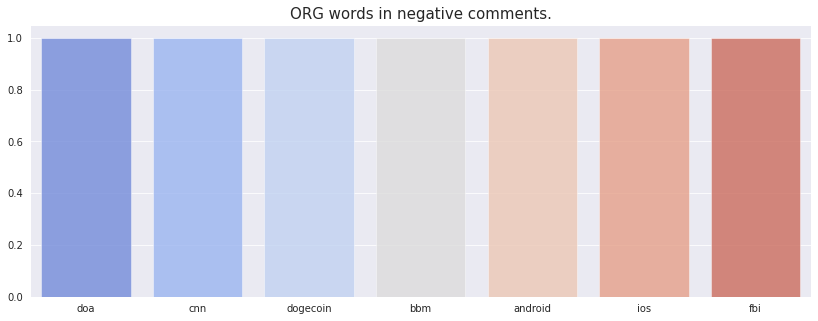

In [80]:
ORG = negative_entities.query("entity == 'ORG'")
ORG = ORG['word'].value_counts()
ORG = ORG[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(14,5));
ORG = sns.barplot(x=ORG.index,y= ORG.values, alpha=0.8,palette="coolwarm");
plt.title('ORG words in negative comments.',fontsize=15);
plt.show();

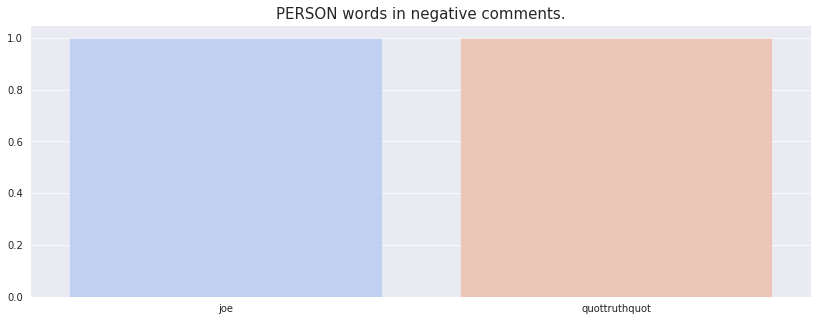

In [81]:
PERSON = negative_entities.query("entity == 'PERSON'")
PERSON = PERSON['word'].value_counts()
PERSON = PERSON[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(14,5));
PERSON = sns.barplot(x=PERSON.index,y= PERSON.values, alpha=0.8,palette="coolwarm");
plt.title('PERSON words in negative comments.',fontsize=15);
plt.show();